# SIFT

The **Scale-Invariant Feature Transform (SIFT)**, published by David Lowe in 1999, is one of the most robust algorithms in computer vision. It transforms an image into a collection of local feature vectors that are invariant to **scaling, rotation, and translation**, and partially invariant to illumination changes.

---

### The Four Main Steps of SIFT

#### 1. Scale-Space Extrema Detection

As we discussed with **DoG**, the first step is identifying potential points of interest across different scales. By using the Difference of Gaussians, SIFT identifies "blobs" that persist across various blurs and sizes, ensuring the feature is **scale-invariant**.

#### 2. Keypoint Localization

Not all blobs are good features. SIFT refines the list by:

* **Sub-pixel Interpolation:** Finding the exact location of the peak of the blob.
* **Removing Low Contrast Points:** Discarding weak blobs that are susceptible to noise.
* **Removing Edges:** Using a principle similar to the Harris Corner Detector (eigenvalues of the Hessian matrix) to eliminate points that are along an edge rather than being a distinct corner/blob.

#### 3. Orientation Assignment

To achieve **rotation invariance**, each keypoint is assigned a "main orientation."

* A neighborhood is taken around the keypoint.
* The gradient magnitude and direction are calculated for every pixel.
* An **Orientation Histogram** is created. The highest peak in this histogram becomes the master orientation of that keypoint.
* All future calculations for this point are performed relative to this orientation.

#### 4. Keypoint Descriptor Generation

Finally, a fingerprint (descriptor) is created for the point:
* A $16 \times 16$ neighborhood is divided into $4 \times 4$ sub-blocks.
* For each sub-block, an 8-bin orientation histogram is created.
* $4 \times 4 \text{ blocks} \times 8 \text{ bins} = \mathbf{128} \text{ values}$.
* This 128-dimensional vector is the "SIFT Descriptor."

---

### Summary of Invariance

| Transformation | SIFT's Solution |
| --- | --- |
| **Scaling** | Search across the DoG Scale-Space Pyramid. |
| **Rotation** | Orient the descriptor relative to the local gradient peak. |
| **Translation** | Features are defined by local neighborhoods, not global coordinates. |
| **Illumination** | Descriptors are normalized (making them invariant to contrast/brightness). |

### Why use SIFT today?

While deep learning (CNNs) has taken over many tasks, SIFT is still widely used in **3D Reconstruction (Structure from Motion)**, **Image Stitching (Panoramas)**, and scenarios where you have very little training data and need a mathematically proven geometric match.

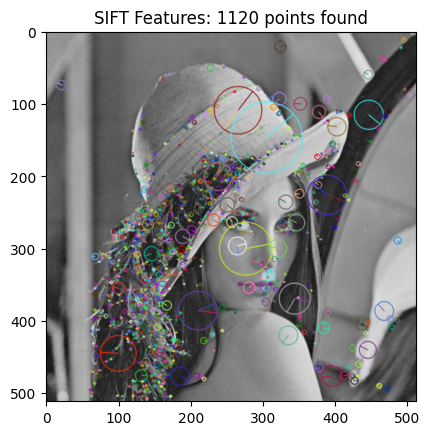

In [2]:
import cv2
import matplotlib.pyplot as plt

# 1. Load image and convert to gray
img = cv2.imread('resources/lena_gray.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 2. Initialize SIFT detector
sift = cv2.SIFT_create()

# 3. Detect keypoints and compute descriptors
# kp: List of keypoints (x, y, scale, orientation)
# des: Matrix of descriptors (N x 128)
kp, des = sift.detectAndCompute(gray, None)

# 4. Draw keypoints with size and orientation
img_with_kp = cv2.drawKeypoints(gray, kp, img, 
                                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB))
plt.title(f'SIFT Features: {len(kp)} points found')
plt.show()

# SURF

**SURF (Speeded Up Robust Features)**, introduced in 2006 by Bay et al., was developed as a faster and more efficient alternative to SIFT. While it maintains a high degree of robustness to rotation and scaling, it is designed for real-time applications where SIFT might be too slow.

---

### 1. Key Innovations in SURF

#### The Hessian Matrix Detector

Instead of using Difference of Gaussians (DoG) like SIFT, SURF uses the **Hessian Matrix** to find points of interest. The Hessian measures the local curvature of the image:

$$H(x, \sigma) = \begin{bmatrix} L_{xx}(x, \sigma) & L_{xy}(x, \sigma) \\ L_{xy}(x, \sigma) & L_{yy}(x, \sigma) \end{bmatrix}$$

A point is considered a feature if the determinant of this matrix is a local maximum.

#### Box Filters (The Speed Secret)

To calculate the second-order derivatives ($L_{xx}, L_{yy}, L_{xy}$) required for the Hessian, SIFT uses Gaussian filters, which are computationally expensive.

* **SURF's Trick:** It approximates Gaussian filters with **Box Filters** (simple rectangular approximations).
* **Integral Images:** Because box filters are just rectangles, SURF uses **Integral Images** to calculate the response at any scale instantly with only four memory lookups.

#### Scale-Space via Filter Resizing

Unlike SIFT, which creates a pyramid by downsampling the image (resizing the pixels), SURF **keeps the image size constant and resizes the filters**. This avoids the need for multiple layers of downsampling and significantly increases speed.

---

### 2. The SURF Descriptor

Once a point is found, SURF creates a 64-dimensional descriptor (half the size of SIFT's 128-D vector):

1. **Orientation:** It calculates Haar-wavelet responses in  and  directions within a circular neighborhood to determine the main orientation.
2. **Square Region:** It takes a square region around the point, aligned to the main orientation, and divides it into  sub-regions.
3. **Features:** For each sub-region, it calculates the sum of Haar-wavelet responses ().
4. **Result:** .

---

### 3. Python Implementation (OpenCV)

**Note:** Like SIFT, SURF was patented. However, while SIFT's patent expired in 2020, SURF's status varies by region. It is often located in the `opencv-contrib-python` package.

---

### 4. SIFT vs. SURF Comparison

| Feature | SIFT | SURF |
| --- | --- | --- |
| **Detection** | Difference of Gaussians (DoG) | Fast-Hessian (Box Filters) |
| **Speed** | Slow | **Fast** (Real-time capable) |
| **Descriptor Size** | 128 Dimensions | 64 Dimensions |
| **Scale-Space** | Image Pyramid (Resizing Image) | Filter Pyramid (Resizing Filter) |
| **Robustness** | Better for rotation/blur | Better for speed/sharpness |

In [ ]:
import cv2
import matplotlib.pyplot as plt

# 1. Load image
img = cv2.imread('resources/lena_gray.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 2. Initialize SURF (Hessian Threshold usually 400-500)
# Note: You may need opencv-contrib installed
surf = cv2.xfeatures2d.SURF_create(400)

# 3. Find keypoints and descriptors
kp, des = surf.detectAndCompute(gray, None)

# 4. Draw keypoints
img_surf = cv2.drawKeypoints(gray, kp, None, (255,0,0), 4)

plt.imshow(img_surf)
plt.title(f'SURF Features: {len(kp)} points')
plt.show()

# HOG

The **Histogram of Oriented Gradients (HOG)** is a powerful feature descriptor used primarily for **object detection**, specifically for detecting humans in images. Unlike SIFT or SURF, which look for "blobs," HOG focuses on the **shape** and **appearance** of an object by looking at the distribution of intensity gradients and edge directions.

It was popularized by Dalal and Triggs in 2005 for pedestrian detection.

---

### 1. How HOG Works (Step-by-Step)

The core idea is that local object appearance and shape can often be described by the distribution of intensity gradients, even without precise knowledge of the corresponding gradient or edge positions.

#### A. Gradient Calculation

The first step is to calculate the horizontal ($G_x$) and vertical ($G_y$) gradients. This is usually done by convolving the image with simple kernels like  $[-1, 0, 1]$.

* **Magnitude:** $G = \sqrt{G_x^2 + G_y^2}$
* **Orientation (Angle):** $\theta = \arctan(\frac{G_y}{G_x})$

#### B. Cell Histograms

The image is divided into small connected regions called **cells** (e.g., $8 * 8$ pixels). For each cell, a histogram of gradient orientations is created.

* The histogram typically has 9 bins covering 0 to 180 degrees.
* Each pixel in the cell casts a weighted vote for a bin based on its gradient magnitude.

#### C. Block Normalization

To account for changes in illumination and contrast, the cells are grouped into larger, overlapping **blocks** (e.g., 2X2 cells). The histograms within each block are concatenated and normalized. This makes the descriptor more robust to shadows and lighting variations.

#### D. The Descriptor Vector

The final HOG descriptor is the concatenation of all normalized block vectors into one massive feature vector.

---

### 2. Why it is great for Pedestrian Detection

HOG captures the "silhouette" of a person. In a typical pedestrian image:

* The **head** creates a specific circular gradient pattern.
* The **torso** and **legs** create strong vertical gradients.
* Because the histogram bins directions, it doesn't matter if the person is wearing a red shirt or a blue shirt; the *shape* (the gradient) remains the same.

---

### 3. Python Implementation (using Scikit-Image)

Scikit-Image provides an excellent utility to compute and visualize HOG descriptors.

### 4. Comparison with Other Descriptors

| Feature | SIFT / SURF | HOG |
| --- | --- | --- |
| **Focus** | Local Points (Blobs) | Global/Semi-local Shape (Silhouettes) |
| **Output** | Set of keypoints | One large feature vector |
| **Best Use Case** | Image Matching / Stitching | Object Detection (Pedestrians, Cars) |
| **Invariance** | Rotation & Scale Invariant | Not naturally scale invariant (uses pyramids) |

### 5. Historical Context on your Chart

On the image you provided earlier, **HOG (2005)** sits in the **Scaling-invariant** row of the **Descriptors** column. While a single HOG calculation isn't scale-invariant, it is almost always used with an **Image Pyramid** (calculating HOG at multiple resizes of the image) to detect people at different distances.

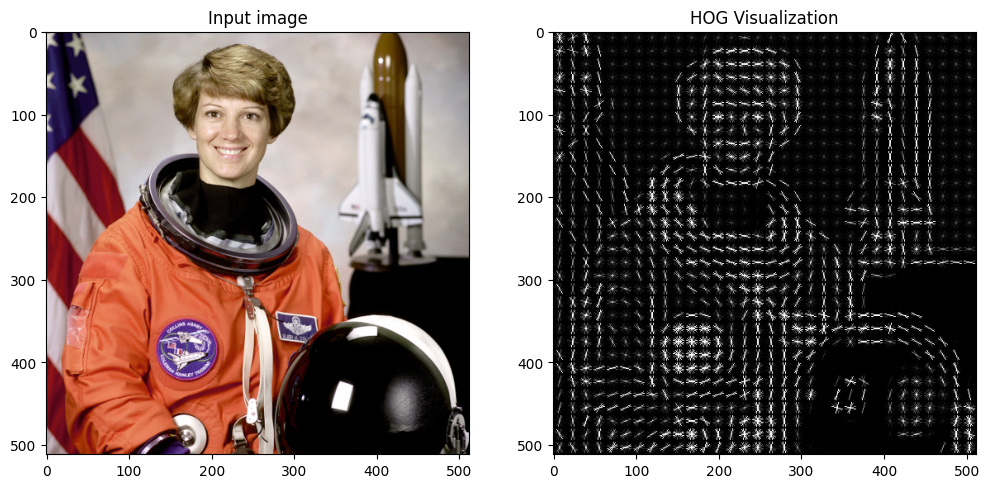

In [ ]:
from skimage.feature import hog
from skimage import data, exposure
import matplotlib.pyplot as plt

# 1. Load an image
image = data.astronaut() # Or a person image
# image = cv2.imread('resources/lena_gray.png')

# 2. Compute HOG
# orientations: number of bins
# pixels_per_cell: size of the cell
# cells_per_block: number of cells in a block
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

# 3. Rescale for better visualization
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# 4. Display
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(image); ax1.set_title('Input image')
ax2.imshow(hog_image_rescaled, cmap='gray'); ax2.set_title('HOG Visualization')
plt.show()

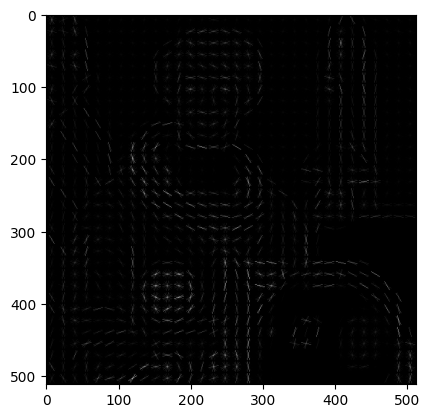

In [9]:
plt.imshow(hog_image, cmap='gray')